# DAMI 2 Project - Histopatologic cancer detection

# Summary:
            
This notebook provides the consolidated work on the project assignment for
the course **DAMI 2 (HT2020)** held at **Stockholm University**. 
            
The project is inspired by the Kaggle competition on the same topic, to be found here:
https://www.kaggle.com/c/histopathologic-cancer-detection/overview
            
and is using the original data set provided by Kaggle for educational purposes AND trying to complete the Kaggle challenge.

Version:    v1.0

Date:       2021-01-03

Autor:      Stefan Libiseller

Email:      stli2360@student.su.se

## The environment used

In [1]:
import sys

#python version
print(sys.version)

3.8.7 (tags/v3.8.7:6503f05, Dec 21 2020, 17:59:51) [MSC v.1928 64 bit (AMD64)]


In [2]:
import tensorflow as tf

#tensorflow version
print(tf.__version__)

2.4.0


In [3]:
#Keras version

print(tf.keras.__version__)

2.4.0


## Importing of libraries

In [6]:
## some common depenencies for the job
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#import tensorflow as tf
import os
import cv2
from datetime import date, datetime

## some additional depenencies for model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc

## specific depenencies for tensorflow and Keras
from tensorflow.keras.optimizers import RMSprop, Adam # Two optimizers that shall be tested
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Global definitions

In [7]:
## image parameters
IMG_ROWS = 96
IMG_COLS = 96
IMG_CHANNELS = 3
IMG_SHAPE = (IMG_ROWS, IMG_COLS, IMG_CHANNELS)

## paths
train_path = './images/train'
test_path = './images/train' #we use the same path in order to use all the labeled training images for testing

## network and training parameters
EPOCHS = 7
BATCH_SIZE = 200
VERBOSE = 1
NB_CLASSES = 1         # Either cancer or not - one output neuron!
VALIDATION_SPLIT = 0.3 # Fraction of Train data reserved for validation
TEST_SPLIT = 0.25       # Fraction of total labeled data ued for test set
#OPTIMIZER = Adam       # Set adam as default optimizier
DROPOUT = 0.3          # Default dropout rate
POOL_SIZE = (2, 2)
KERNEL_SIZE = (3, 3)
RANDOM_STATE = 8
STEPS_PER_EPOCH = 200

EVAL_STEPS = 100  # had to be reduced to avoid TF killing the kernel due to exceeding 10% of system memory

MODEL = models.Sequential()


NOTE: Regarding ADAM: According to Kingma et al., 2014, the method is "computationally efficient, has little memory requirement, invariant to diagonal rescaling of gradients, and is well suited for problems that are large in terms of data/parameters".

http://arxiv.org/abs/1412.6980

## Importing of data

In this dataset, you are provided with a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. You are predicting the labels for the images in the test folder. **A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue.** Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

The original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates. We have otherwise maintained the same data and splits as the PCam benchmark.

In [8]:
## import the description file for test data 
labels = pd.read_csv('./images/train_labels.csv',dtype=str)
sample_submission = pd.read_csv('./images/sample_submission.csv')

### Manual evaluation of source data

In [9]:
# show the top 5 entries from training data
print(labels.head())

                                         id label
0  f38a6374c348f90b587e046aac6079959adf3835     0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77     1
2  755db6279dae599ebb4d39a9123cce439965282d     0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08     0
4  068aba587a4950175d04c680d38943fd488d6a9d     0


In [10]:
# check the number of labels
print("Number of unique ids in DF: ", labels['id'].nunique())
print("Number of total ids in DF: ", labels['id'].count())
print("Number of unique labels in DF: ", labels['label'].nunique())
print("Number of total labels in DF: ", labels['label'].count())

# check for nan
print("\nNaN values present? ", labels.isnull().values.any())

# check for IDs that have too short/long id values
mask = (labels['id'].str.len() != 40)
labels_err = labels.loc[mask]

print("\nFollowing ids have a wrong lentght:\n",labels_err)

# some more descriptive data
print("\nDescriptive data:\n(0 - no cancer, 1 - cancer)\n\n", labels.label.value_counts())

Number of unique ids in DF:  220025
Number of total ids in DF:  220025
Number of unique labels in DF:  2
Number of total labels in DF:  220025

NaN values present?  False

Following ids have a wrong lentght:
 Empty DataFrame
Columns: [id, label]
Index: []

Descriptive data:
(0 - no cancer, 1 - cancer)

 0    130908
1     89117
Name: label, dtype: int64


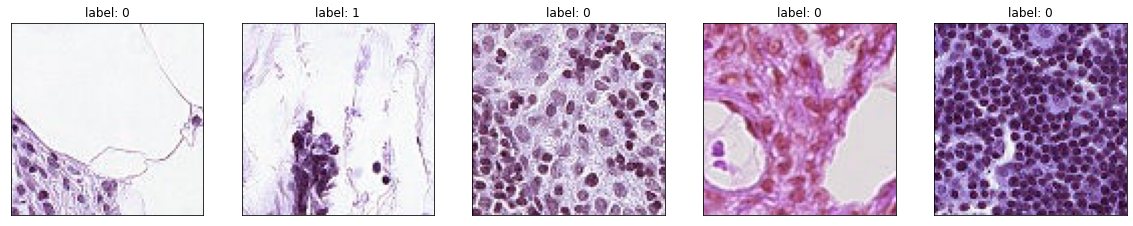

In [11]:
# load 5 training images for preview

count = 5
figure, axis = plt.subplots(1, len(labels[:count]), figsize = (20, 10))
for img, ax in enumerate(axis):
    ax.imshow(cv2.imread(train_path + "/" + labels.id[img] + ".tif")) #For Windows filesystem
    ax.set_title("label: " + str(labels.label[img]))
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

### Validating the file and ID counts

In [12]:
# show the number of files in the directories
print("Training images files: ", len(os.listdir(train_path)))
print("Training labels: ", len(labels.index))
print("Testing images files: ", len(os.listdir(test_path)))

Training images files:  220025
Training labels:  220025
Testing images files:  220025


### Data preparation

In [13]:
# data preparation for import

# extend the labels DF with the file paths
#labels['file_path'] = labels.apply(lambda x: train_path + "/" + x['id'] + ".tif", axis=1)
labels['file_path'] = labels.apply(lambda x: x['id'] + ".tif", axis=1)


In [14]:
#del df_trainvalid
#del df_train
#del df_validation

In [15]:
## prepare the train/validation data split
# stratify to generate a balanced validation set


### NOTE: We are using the training set from Kaggle also for the test set, as there is not label data for the 
### Kaggle test set available already.

# first splitting training and testing set
df_trainvalid, df_test = train_test_split(labels, test_size=TEST_SPLIT, random_state=RANDOM_STATE, stratify=labels['label'])


In [16]:
#the split the training and validation set again
df_train, df_validation = train_test_split(df_trainvalid, test_size=VALIDATION_SPLIT, random_state=RANDOM_STATE, stratify=df_trainvalid['label'])


In [17]:
## some more tests for the train data set

df_train.head()
print("Number of unique labels in DF validation: ", df_train['label'].nunique())
print("\nDescriptive data:\n(0 - no cancer, 1 - cancer)\n\n", df_train.label.value_counts())

Number of unique labels in DF validation:  2

Descriptive data:
(0 - no cancer, 1 - cancer)

 0    68726
1    46786
Name: label, dtype: int64


In [18]:
## some more tests for the validation data set

df_validation.head()
print("Number of unique labels in DF validation: ", df_validation['label'].nunique())
print("\nDescriptive data:\n(0 - no cancer, 1 - cancer)\n\n", df_validation.label.value_counts())

Number of unique labels in DF validation:  2

Descriptive data:
(0 - no cancer, 1 - cancer)

 0    29455
1    20051
Name: label, dtype: int64


In [19]:
print("Number of unique labels in DF validation: ", df_test['label'].nunique())
print("\nDescriptive data:\n(0 - no cancer, 1 - cancer)\n\n", df_test.label.value_counts())

Number of unique labels in DF validation:  2

Descriptive data:
(0 - no cancer, 1 - cancer)

 0    32727
1    22280
Name: label, dtype: int64


## Image preprocessing

In [20]:
## reading image data into generators

# training data generator
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(dataframe=df_train, directory=train_path,
                x_col = 'file_path', y_col = 'label', target_size=(IMG_ROWS, IMG_COLS),
                batch_size=BATCH_SIZE, class_mode='binary')


Found 115512 validated image filenames belonging to 2 classes.


In [21]:
# validation data generator
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(dataframe=df_validation, directory=train_path,
                x_col = 'file_path', y_col = 'label', target_size=(IMG_ROWS, IMG_COLS),
                batch_size=BATCH_SIZE, class_mode='binary')


Found 49506 validated image filenames belonging to 2 classes.


In [22]:
# test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(dataframe=df_test, directory=test_path,
                x_col = 'file_path', y_col = 'label', target_size=(IMG_ROWS, IMG_COLS),
                batch_size=int(round(len(df_train) // BATCH_SIZE)), class_mode='binary')

Found 55007 validated image filenames belonging to 2 classes.


## Model definition

In [23]:
def build_model(KERNEL_SIZE, INPUT_SHAPE, DROPOUT, NB_CLASSES):
    model = models.Sequential() 

    
    #first layer
    model.add(layers.Convolution2D(16, KERNEL_SIZE, activation='relu', input_shape=INPUT_SHAPE))
    model.add(layers.Dropout(DROPOUT)) 
    model.add(layers.MaxPooling2D(pool_size=POOL_SIZE, strides=(2, 2)))
    

    #second layer
    model.add(layers.Convolution2D(64, KERNEL_SIZE, activation='relu'))
    model.add(layers.Dropout(DROPOUT)) 
    model.add(layers.MaxPooling2D(pool_size=POOL_SIZE, strides=(2, 2)))
    

    #dense netork layer
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu')) #256?
    #model.add(layers.Dropout(DROPOUT))

    #output layer
    model.add(layers.Dense(1, activation='sigmoid'))
   

    
    return model

In [24]:
# build the model
model = build_model(KERNEL_SIZE, IMG_SHAPE, DROPOUT,NB_CLASSES)

# show the summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 16)        448       
_________________________________________________________________
dropout (Dropout)            (None, 94, 94, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 45, 64)        9280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 45, 45, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 30976)            

## Reloading the model

In [26]:
from tensorflow import keras

#model = keras.models.load_model("<name>")
model = keras.models.load_model("CancerDetection_sequential_6_Adam_2021-01-02 19-14-54.h5")

# *** RELOAD UNTIL HERE IF KERNEL DIES ***

## Training the initial model

In [145]:
# compile the model
model.compile('Adam', loss="binary_crossentropy", metrics=["accuracy"])

In [146]:
# define the checkpoints

tensorboard = TensorBoard(
    log_dir = './logs',
    write_graph=True,
    write_images=True
)


earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto'
)

# enable Callbacks
callbacks = [tensorboard, earlystop]

In [147]:
# fit the model

history_initial = model.fit_generator(
    train_generator, 
    steps_per_epoch  = STEPS_PER_EPOCH, 
    validation_data  = validation_generator,
    validation_steps = 200,
    epochs = EPOCHS, 
    verbose = VERBOSE,
    callbacks = callbacks
)

C:\Users\libis.LIBI-T470\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/7
200/200 [==============================] - 513s 3s/step - loss: 1.1316 - accuracy: 0.6807 - val_loss: 0.5086 - val_accuracy: 0.7696
Epoch 2/7
200/200 [==============================] - 503s 3s/step - loss: 0.4672 - accuracy: 0.7871 - val_loss: 0.5006 - val_accuracy: 0.7773
Epoch 3/7
200/200 [==============================] - 501s 3s/step - loss: 0.4626 - accuracy: 0.7874 - val_loss: 0.4926 - val_accuracy: 0.7773
Epoch 4/7
200/200 [==============================] - 501s 3s/step - loss: 0.4566 - accuracy: 0.7918 - val_loss: 0.4724 - val_accuracy: 0.7979
Epoch 5/7
200/200 [==============================] - 500s 2s/step - loss: 0.4450 - accuracy: 0.7941 - val_loss: 0.4865 - val_accuracy: 0.7909
Epoch 6/7
200/200 [==============================] - 505s 3s/step - loss: 0.4394 - accuracy: 0.8021 - val_loss: 0.4847 - val_accuracy: 0.8051
Epoch 7/7
200/200 [==============================] - 502s 3s/step - loss: 0.4329 - accuracy: 0.8075 - val_loss: 0.4847 - val_accuracy: 0.7852


In [27]:
model.name

'sequential_6'

In [149]:
model.optimizer

### Evaluating the model

In [153]:
# evaluating the model while using a generator
print(EVAL_STEPS)

100


In [154]:
scores_initial = model.evaluate_generator(test_generator, EVAL_STEPS-5)

C:\Users\libis.LIBI-T470\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


In [155]:
scores_initial  ## test loss and test accuracy

[0.4824729263782501, 0.7881784439086914]

### Plotting the model

In [38]:
# define the visualization of the model
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(20,7))
    ax[0].set_title('Loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Training loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('Accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Training accuracy")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
    ax[0].legend()
    ax[1].legend()
    ax[0].grid()
    ax[1].grid()

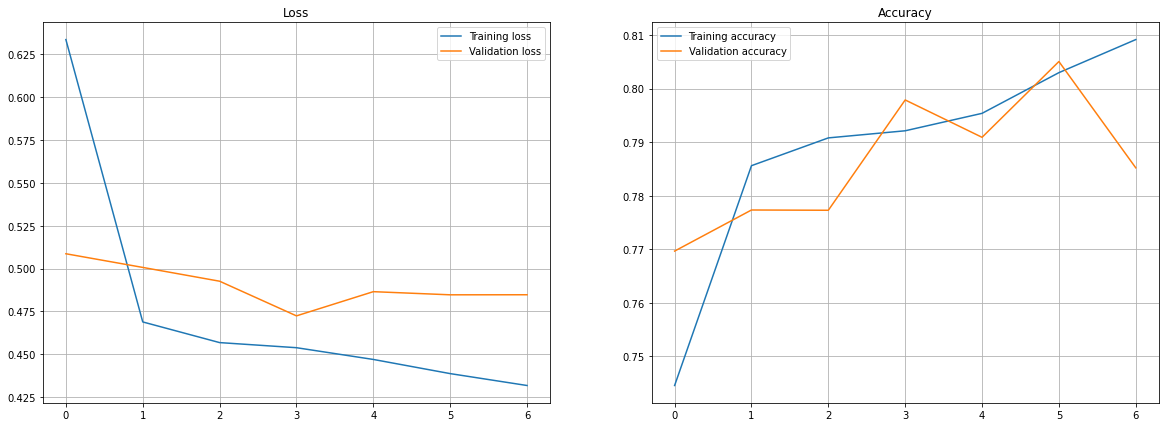

In [150]:
#plotting the initial model
plot_training_history(history_initial)

### Saving the model

In [151]:
## save the  model incl. weights and parameters into a keras file

timestamp = datetime.now().strftime("%Y-%m-%d %H-%M-%S")
modelname = "CancerDetection_" + model.name + "_Adam_" + str(timestamp) + ".h5"
model.save(modelname)

## Testing another model

The model has been chosen from existing solutions for the Kaggle challenge. It has been selected, as it is still not used pre-fitted models, but comes with much higher complexity. This shall allow to highlight the differences.

Source: https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb

### Reload data if needed

In [28]:
IMAGE_SIZE = 96

In [29]:
# Reload the model if needed
from tensorflow import keras
#model = keras.models.load_model("<name>")
model2 = keras.models.load_model("CancerDetection_reference_Adam_2021-01-02 18-10-00.h5")

### Training the reference model

In [50]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop, Adam

kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.5

model2 = Sequential()
model2.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model2.add(Conv2D(first_filters, kernel_size, use_bias=False))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPool2D(pool_size = pool_size)) 
model2.add(Dropout(dropout_conv))

model2.add(Conv2D(second_filters, kernel_size, use_bias=False))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(Conv2D(second_filters, kernel_size, use_bias=False))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPool2D(pool_size = pool_size))
model2.add(Dropout(dropout_conv))

model2.add(Conv2D(third_filters, kernel_size, use_bias=False))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(Conv2D(third_filters, kernel_size, use_bias=False))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPool2D(pool_size = pool_size))
model2.add(Dropout(dropout_conv))

#model.add(GlobalAveragePooling2D())
model2.add(Flatten())
model2.add(Dense(256, use_bias=False))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(Dropout(dropout_dense))
model2.add(Dense(1, activation = "sigmoid"))


In [51]:
# show the summary
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 92, 92, 32)        9216      
_________________________________________________________________
batch_normalization (BatchNo (None, 92, 92, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 92, 92, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 46, 46, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 44, 44, 64)       

### Fitting the model

In [52]:
# Compile the model
model2.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])

In [53]:
# fit the model

history_comparison = model2.fit_generator(
    train_generator, 
    steps_per_epoch  = STEPS_PER_EPOCH, 
    validation_data  = validation_generator,
    validation_steps = 200,
    epochs = EPOCHS, 
    verbose = VERBOSE,
    callbacks = callbacks
)

Epoch 1/7
200/200 [==============================] - 3206s 16s/step - loss: 0.5694 - accuracy: 0.7532 - val_loss: 2.8428 - val_accuracy: 0.5908
Epoch 2/7
200/200 [==============================] - 3151s 16s/step - loss: 0.3920 - accuracy: 0.8292 - val_loss: 1.1332 - val_accuracy: 0.5968
Epoch 3/7
200/200 [==============================] - 3452s 17s/step - loss: 0.3665 - accuracy: 0.8448 - val_loss: 0.7959 - val_accuracy: 0.6711
Epoch 4/7
200/200 [==============================] - 3224s 16s/step - loss: 0.3520 - accuracy: 0.8472 - val_loss: 1.1236 - val_accuracy: 0.5948
Epoch 5/7
200/200 [==============================] - 3199s 16s/step - loss: 0.3370 - accuracy: 0.8566 - val_loss: 1.1655 - val_accuracy: 0.6277
Epoch 6/7
200/200 [==============================] - 3163s 16s/step - loss: 0.3146 - accuracy: 0.8694 - val_loss: 1.2055 - val_accuracy: 0.6720
Epoch 7/7
200/200 [==============================] - 3118s 16s/step - loss: 0.3050 - accuracy: 0.8730 - val_loss: 0.8471 - val_accuracy:

### Plotting the model

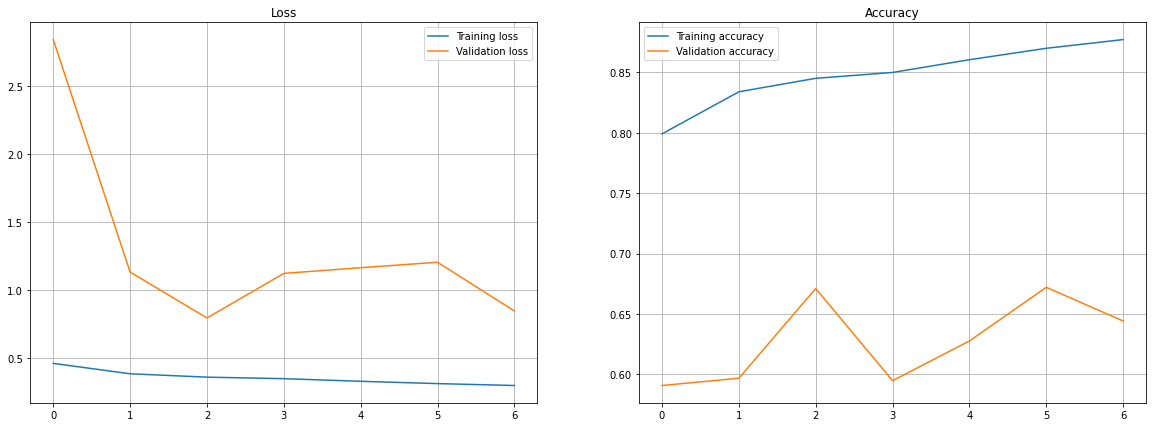

In [57]:
#plotting the initial model
plot_training_history(history_comparison)

### Evaluating the model

In [115]:
# evaluating the model while using a generator
scores_comparison = model2.evaluate_generator(test_generator, EVAL_STEPS-5)

In [116]:
scores_comparison  ## test loss and test accuracy

[0.8433091044425964, 0.6462647318840027]

### Saving the model

In [121]:
## save the  model incl. weights and parameters into a keras file
timestamp = datetime.now().strftime("%Y-%m-%d %H-%M-%S")
modelname2 = "CancerDetection_" + "reference" + "_Adam_" + str(timestamp) + ".h5"
model2.save(modelname2)

## Selecting the best model - Compare ROC curve

### creating a generator for the prediction

In [62]:
roc_datagen = ImageDataGenerator(rescale=1./255)

roc_generator = roc_datagen.flow_from_dataframe(dataframe=df_test, directory=test_path,
                x_col = 'file_path', y_col = 'label', target_size=(IMG_ROWS, IMG_COLS),
                batch_size=1, class_mode='binary', shuffle=False)

Found 55007 validated image filenames belonging to 2 classes.


### predicting the models

In [63]:
prediction_initial = model.predict_generator(roc_generator, steps=len(roc_generator), verbose=1)

    7/55007 [..............................] - ETA: 9:33 

C:\Users\libis.LIBI-T470\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


55007/55007 [==============================] - 409s 7ms/step


In [64]:
prediction_initial

array([[0.05683735],
       [0.37568682],
       [0.16220278],
       ...,
       [0.01971015],
       [0.03546679],
       [0.750523  ]], dtype=float32)

In [71]:
prediction_comparison = model2.predict_generator(roc_generator, steps=len(roc_generator), verbose=1)

    6/55007 [..............................] - ETA: 11:27

C:\Users\libis.LIBI-T470\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


55007/55007 [==============================] - 755s 14ms/step


In [72]:
prediction_comparison

array([[0.02120528],
       [0.41172397],
       [0.06212565],
       ...,
       [0.03261083],
       [0.00349167],
       [0.96575326]], dtype=float32)

### plotting the ROC curve

In [68]:
def plot_roc(prediction, generator):
        
    FPrate, TPrate, threshold = roc_curve(generator.classes, prediction)
    areauc = auc(FPrate, TPrate)
    
    plt.plot(FPrate, TPrate, label="AUC = {:.2f}".format(areauc))
    plt.plot([0, 1], [0, 1], "g--")
    plt.title('ROC curve')
    plt.xlabel('FP rate')
    plt.ylabel('TP rate')
    plt.grid()
    plt.legend()
    plt.show()

#### Initial model

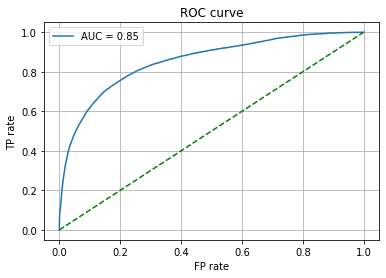

In [69]:
plot_roc(prediction_initial, roc_generator)

#### Reference model

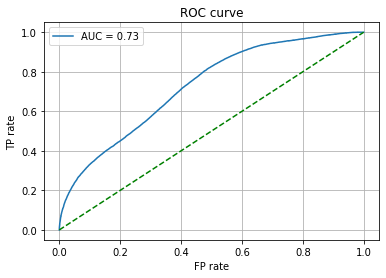

In [73]:
plot_roc(prediction_comparison, roc_generator)